In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import astropy
import astropy.units as u
from astropy import cosmology
# import astropy.cosmology.units as cu
from astropy.cosmology import z_at_value

from fitsio import FITS
from astropy.table import Table

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

H0 =70  #km/s/Mpc
H0_astropy =70  * u.km/u.s/u.Mpc
Om = 0.286

cosmo = astropy.cosmology.FlatLambdaCDM(H0=H0, Om0=Om)

h = 0.7

file_path = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

filepath =  r"/bsuscratch/shuleicao/Cardinalv3/"

In [2]:
## Cardinal
redmapper_file_cl = FITS(filepath+"redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog.fit", mode=0)
redmapper_file_me = FITS(filepath+"redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog_members.fit", mode=0)
redmapper_cl = Table(redmapper_file_cl[1].read())
redmapper_me = Table(redmapper_file_me[1].read())
pmem = redmapper_me['p']*redmapper_me['pfree']*redmapper_me['theta_i']*redmapper_me['theta_r']
redmapper_me = redmapper_me[pmem>0.1]
# Clusters  Cardinal
z_BCG = redmapper_cl['cg_spec_z'] 
z_lambda = redmapper_cl['z_lambda']
Lambda = redmapper_cl['lambda'] 
sel = (z_BCG != -1) & (0.35 <= z_lambda) & (z_lambda<= 0.5)
ID_cl = redmapper_cl['mem_match_id'][sel] 
z_BCG = z_BCG[sel]
z_lambda = z_lambda[sel]
Lambda = Lambda[sel]

# Members
z_mem = redmapper_me['zspec']
sel = (z_mem != -1)
z_mem = z_mem[sel]
ID_mem = redmapper_me['mem_match_id'][sel]

mag_i = np.array([item[2] for item in np.array(redmapper_me['mag'])])[sel]

#applying the Lstar filter
exp = (mag_i - 22.44-3.36*np.log10(z_mem)-0.273*np.log10(z_mem)**2+0.0618*np.log10(z_mem)**3+0.0227*np.log10(z_mem)**4) / -2.5
lstar_frac = 10**exp
sel = (lstar_frac >= 0.6)
z_mem = z_mem[sel]
ID_mem = ID_mem[sel]

#filtering out galaxies that don't belong to clusters with z_BCG
sel = np.isin(ID_mem, ID_cl)
ID_mem = ID_mem[sel]
z_mem = z_mem[sel]

delz = np.array([])
delzov1pz = np.array([])

#calculating delta z for each member
for i in range(len(ID_cl)):
    sel = (ID_mem == ID_cl[i])
    delz = np.concatenate((delz, z_mem[sel] - z_BCG[i]))
    delzov1pz = np.concatenate((delzov1pz, (z_mem[sel] - z_BCG[i]) / (1 + z_BCG[i]))) 


In [3]:
def velocity_to_dzov1pz(z, v):
    v_ref = H0_astropy * (cosmo.comoving_distance(z) / (1+z)) 

    chi = ((v_ref + v*u.km/u.s)/H0_astropy)*(1+z)
    
    dzpz = z_at_value(cosmo.comoving_distance, chi)
    
    return (dzpz-z)/(1+z)

[0.44798404 0.0016832  0.01085474 0.03939809]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.39360954 0.00208399 0.00921631 0.03731521]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.30797705 0.00258335 0.01494213 0.03983983]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.2468885  0.00317663 0.01606739 0.04756161]


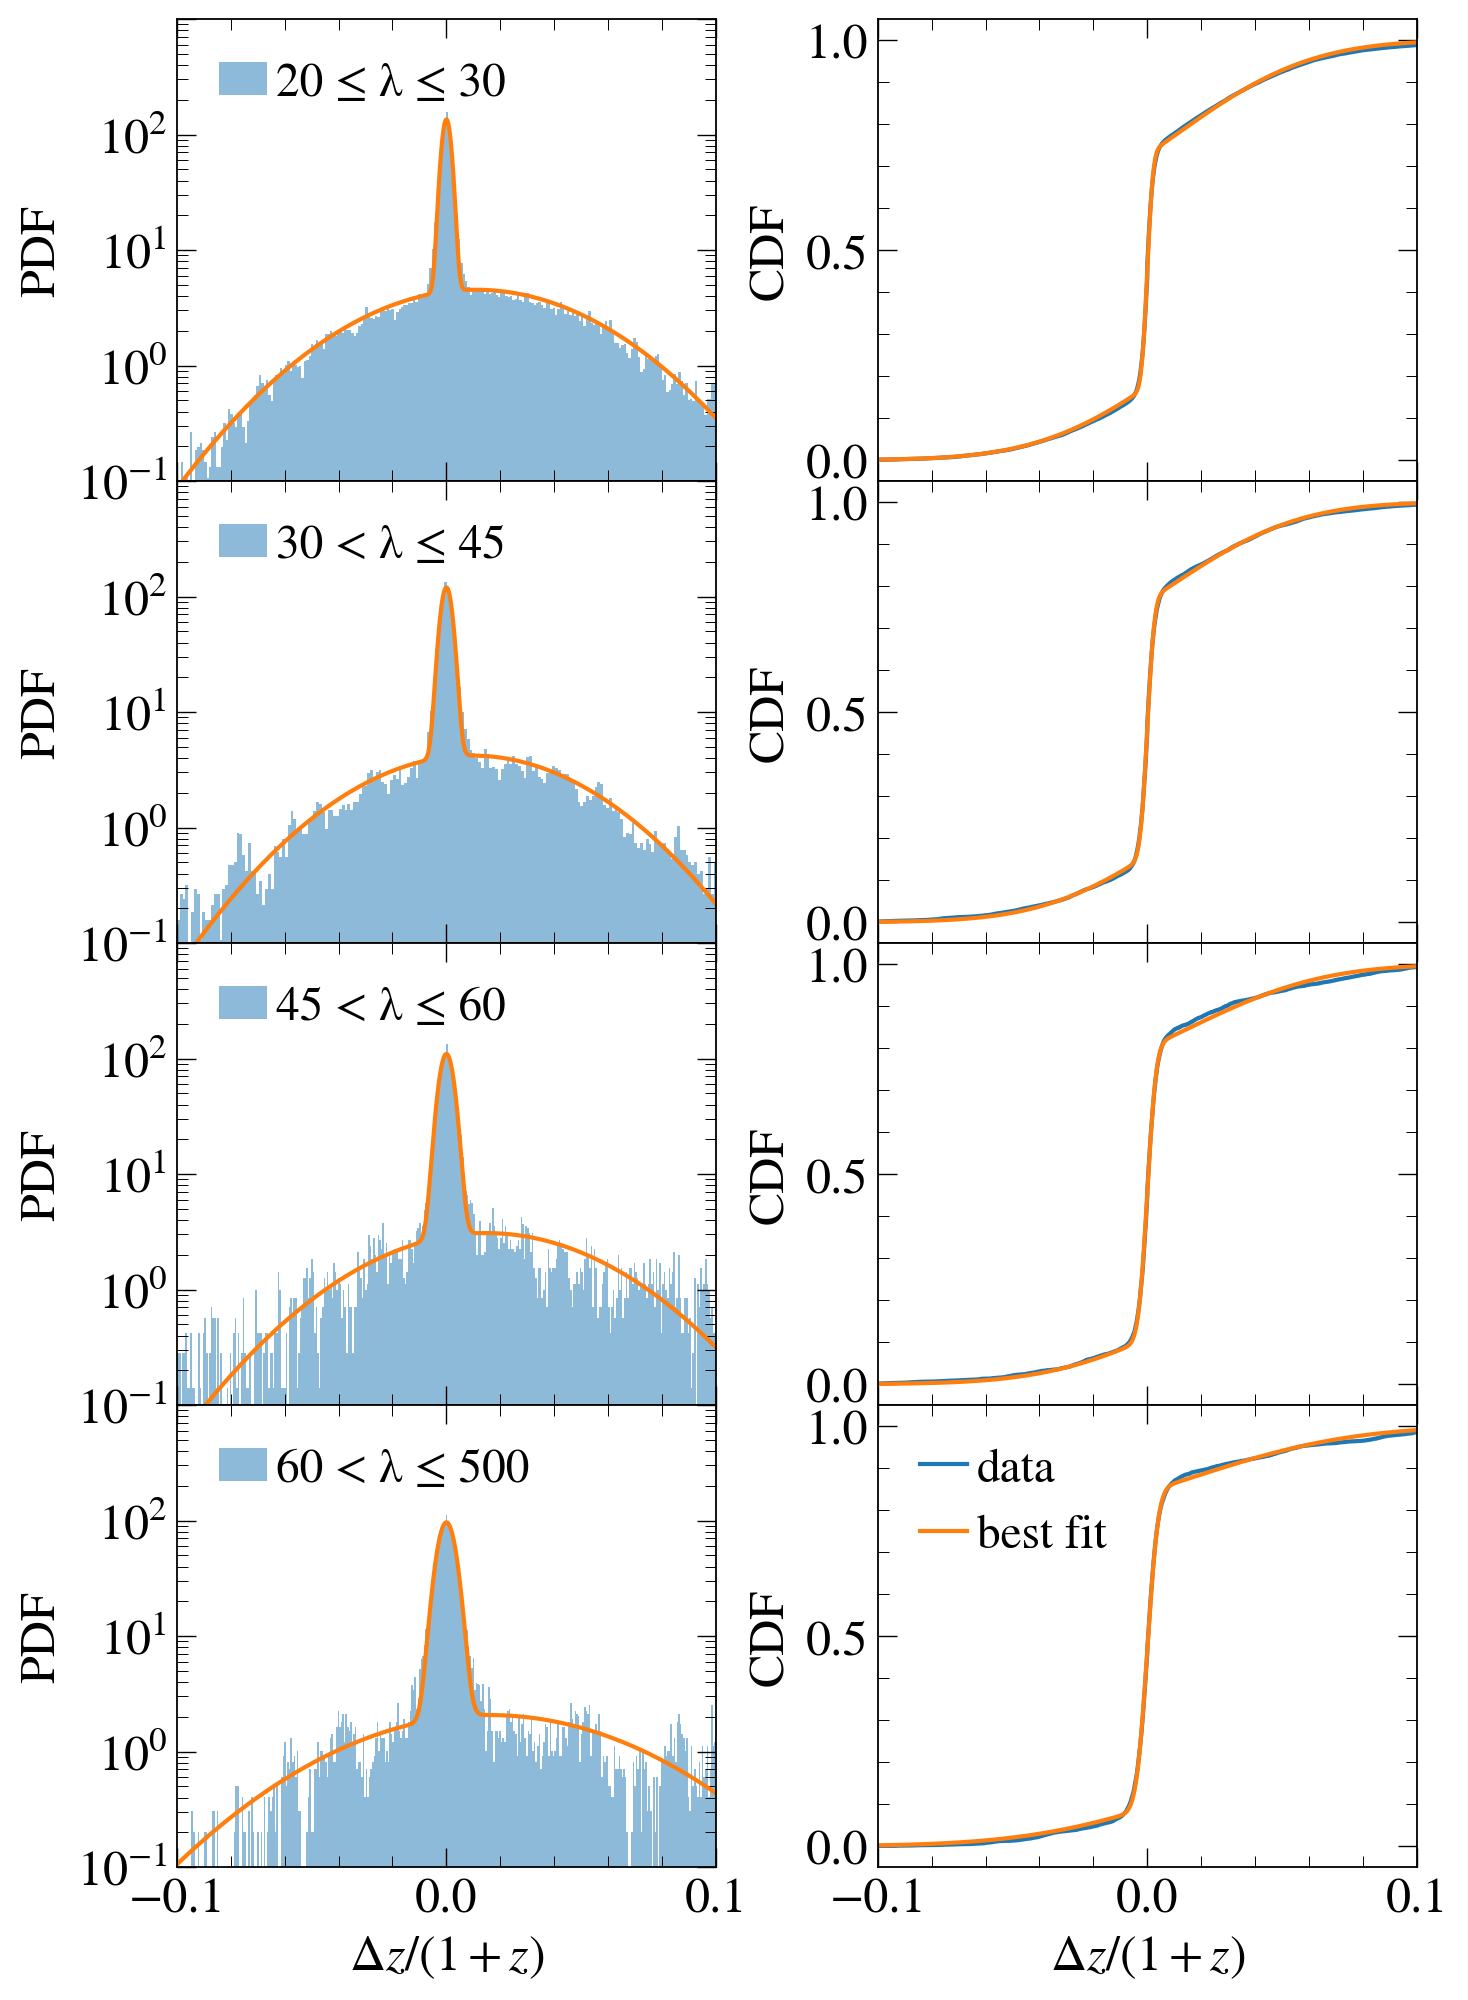

In [16]:
from matplotlib.ticker import MaxNLocator

myles_bin_edges = np.array([20,30,45,60,500]) #richness bins

myles_sigma_cl = np.array([379, 503, 614, 634, 770, 1060]) #km/s
myles_mean_bin_richness = np.array([9.11618, 23.4515,  31.8795,  42.2766,  57.9498,  84.7792])

myles_f_proj = np.array([0.392, 0.265, 0.243, 0.251, 0.137, 0.083])
myles_b_lambda = np.array([0.157, 0.126, 0.127, 0.160, 0.078, 0.033])

sigma_proj = 8689 #km/s
mu_proj = 1299 #km/s

mean_bin_richness = []

def dbl_gauss(delz, f_proj, sigma_cl, mu_proj, sigma_proj):
    return (1 - f_proj) * norm.pdf(delz, loc=0, scale=sigma_cl) + f_proj * norm.pdf(delz, loc=mu_proj, scale=sigma_proj)

def dbl_gauss_cdf(delz, f_proj, sigma_cl, mu_proj, sigma_proj):
    return (1 - f_proj) * norm.cdf(delz, loc=0, scale=sigma_cl) + f_proj * norm.cdf(delz, loc=mu_proj, scale=sigma_proj)

bf_f_proj = np.zeros(len(myles_bin_edges) - 1)
bf_sigma_cl = np.zeros(np.shape(bf_f_proj))
bf_mu_proj = np.zeros(np.shape(bf_f_proj))
bf_sigma_proj = np.zeros(np.shape(bf_f_proj))

fig, axs = plt.subplots(4, 2, figsize=(8, 12), sharex=True)

for i in range(len(myles_bin_edges) - 1):
    # Selecting halos in current richness bin
    if i != 0:
        sel = (myles_bin_edges[i] < Lambda) & (Lambda <= myles_bin_edges[i+1])
        legend = f'{myles_bin_edges[i]} < λ ≤ {myles_bin_edges[i+1]}'
    else:
        sel = (myles_bin_edges[i] <= Lambda) & (Lambda <= myles_bin_edges[i+1])
        legend = f'{myles_bin_edges[i]} ≤ λ ≤ {myles_bin_edges[i+1]}'

    mean_z = np.mean(z_BCG[sel])  # Needed for converting from redshift to km/s
    sel_ID_cl = ID_cl[sel]  # Getting ID's to select corresponding members

    mean_bin_richness.append(np.mean(Lambda[sel]))  # Getting mean richness for x-axis on plots

    # Selecting members that correspond to halos
    sel = np.isin(ID_mem, sel_ID_cl)
    delzov1pz_sel = delzov1pz[sel]

    # Sorting delta z to make CDF
    sel = np.argsort(delzov1pz_sel)
    delzov1pz_sel = delzov1pz_sel[sel]

    cdf = (np.arange(len(delzov1pz_sel)) + 1.0) / len(delzov1pz_sel)

    bf_params = curve_fit(dbl_gauss_cdf, delzov1pz_sel, cdf, p0=[myles_f_proj[i],velocity_to_dzov1pz(mean_z, myles_sigma_cl[i]),
                                                                 velocity_to_dzov1pz(mean_z, mu_proj), velocity_to_dzov1pz(mean_z, sigma_proj),],)[0]
    print(bf_params)
    if (bf_params[1] < bf_params[3]):

        bf_f_proj[i] = bf_params[0]
        bf_sigma_cl[i] = bf_params[1]
        bf_sigma_proj[i] = bf_params[3]
    else:
        bf_f_proj[i] = 1 - bf_params[0]
        bf_sigma_cl[i] = bf_params[3]
        bf_sigma_proj[i] = bf_params[1]
    # print(bf_params)
    delz_input = np.linspace(-0.11, 0.11, 1000)

    axs[i, 0].hist(delzov1pz_sel, bins=555, density=True, label=legend, alpha=0.5)
    axs[i, 0].plot(delz_input, dbl_gauss(delz_input, bf_params[0], bf_params[1], bf_params[2], bf_params[3])) #, label='best fit'
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim([1e-1, 1e3])
    axs[i, 0].set_ylabel('PDF')
    axs[i, 0].set_xlim((-0.1, 0.1))
    axs[i, 0].grid(visible=False)
    

    axs[i, 1].plot(delzov1pz_sel, cdf, label='data')
    axs[i, 1].plot(delz_input, dbl_gauss_cdf(delz_input, bf_params[0], bf_params[1], bf_params[2], bf_params[3]), label='best fit')
    axs[i, 1].set_xlim((-0.1, 0.1))
    axs[i, 1].set_ylabel('CDF')
    axs[i, 1].grid(visible=False)

    axs[i, 0].legend(loc='upper left', frameon=False, fontsize=17,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)
    axs[3, 1].legend(loc='best', frameon=False, fontsize=17,
                        handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)
    y_labels = axs[i, 0].get_yticklabels()
    y_labels[-2].set_visible(False)

# Set the x and y-axis labels for the bottom subplots
for ax in axs[-1, :]:
    ax.set_xlabel('$\Delta z/(1+z)$')
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0.3)
plt.savefig('Images/cardinal_035_05_delta_z.png', facecolor='white')
plt.show()



In [17]:
redmapper_cl = redmapper_cl[(redmapper_cl['z']>=0.2) & (redmapper_cl['z']<=0.65)]
redmapper_me = redmapper_me[(redmapper_me['z']>=0.2) & (redmapper_me['z']<=0.65)]

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]']
redmapper_cl['redshift_range'] = pd.cut(redmapper_cl['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]],
                                            labels=zlabels).astype(str)
redmapper_me['redshift_range'] = pd.cut(redmapper_me['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]],
                                            labels=zlabels).astype(str)

/tmp/ipykernel_227282/3868838293.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


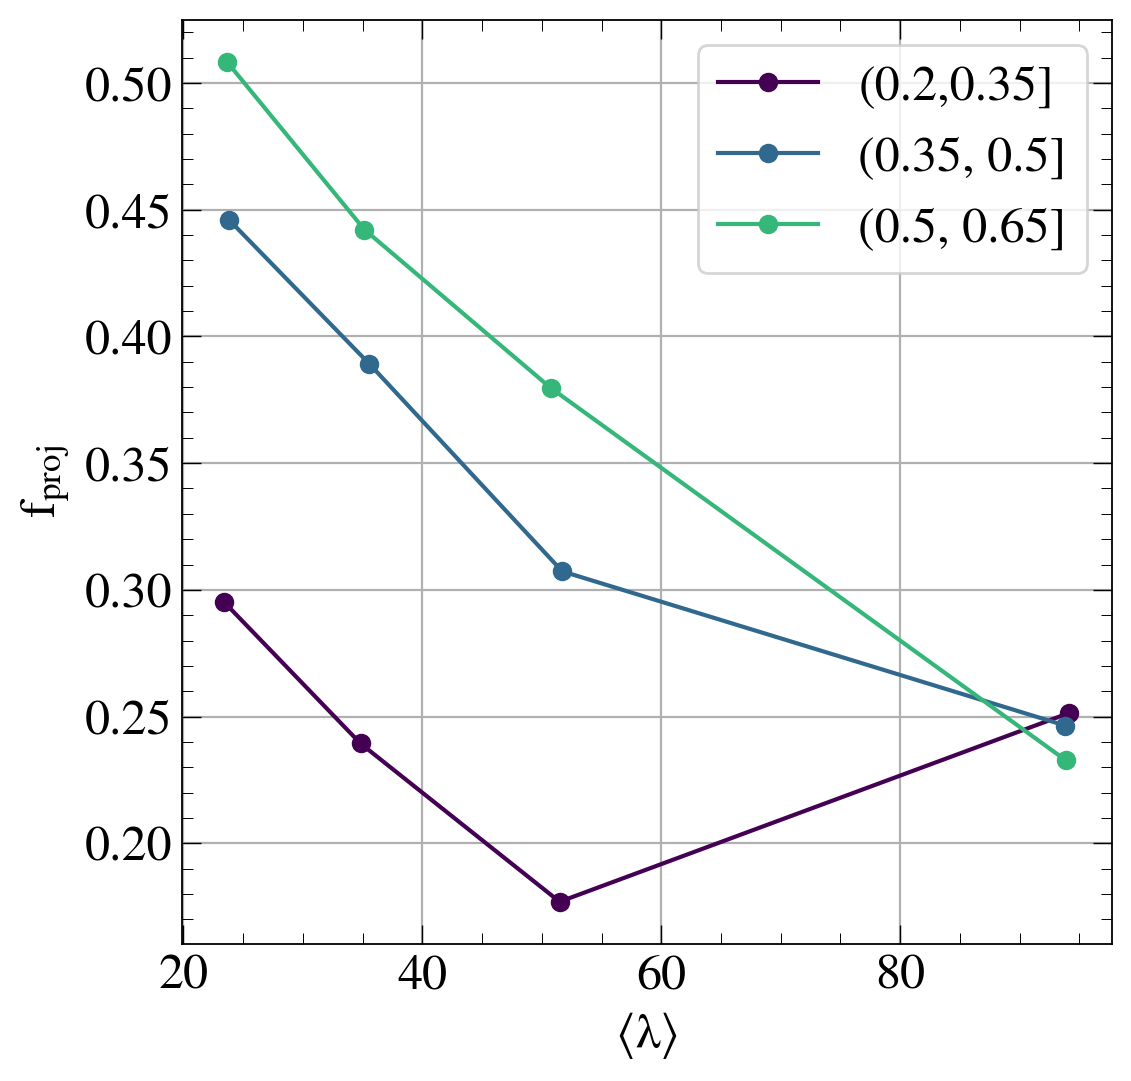

In [20]:
import matplotlib.cm as cm

grouped_cl = redmapper_cl.group_by('redshift_range')
grouped_me = redmapper_me.group_by('redshift_range')

bf_f_proj = np.zeros(len(myles_bin_edges) - 1)
bf_sigma_cl = np.zeros(np.shape(bf_f_proj))
bf_mu_proj = np.zeros(np.shape(bf_f_proj))
bf_sigma_proj = np.zeros(np.shape(bf_f_proj))

# colors = ['red','blue','green','violet','cyan']
cmap = cm.get_cmap('viridis')
group_names = grouped_cl.groups.keys

for c, group_name in enumerate(group_names):
    mean_bin_richness = []
    group_indices = np.where(grouped_cl.groups.keys == group_name)[0]
    start_index = grouped_cl.groups.indices[group_indices[0]]
    end_index = grouped_cl.groups.indices[group_indices[0] + 1] - 1
    
    clusters = grouped_cl[start_index:end_index+1]
    z_BCG = clusters['cg_spec_z'] 
    z_lambda = clusters['z_lambda']
    Lambda = clusters['lambda'] 
    sel = (z_BCG != -1) #& (0.2 <= z_lambda) & (z_lambda <= 0.35)
    ID_cl = clusters['mem_match_id'][sel] 
    z_BCG = z_BCG[sel]
    z_lambda = z_lambda[sel]
    Lambda = Lambda[sel]
    
    
    group_indices = np.where(grouped_me.groups.keys == group_name)[0]
    start_index = grouped_me.groups.indices[group_indices[0]]
    end_index = grouped_me.groups.indices[group_indices[0] + 1] - 1
    
    members = grouped_me[start_index:end_index+1]
    z_mem = members['zspec']
    sel = (z_mem != -1)
    z_mem = z_mem[sel]
    ID_mem = members['mem_match_id'][sel]

    mag_i = np.array([item[2] for item in np.array(members['mag'])])[sel]


    #applying the Lstar filter
    exp = (mag_i - 22.44-3.36*np.log10(z_mem)-0.273*np.log10(z_mem)**2+0.0618*np.log10(z_mem)**3+0.0227*np.log10(z_mem)**4) / -2.5
    lstar_frac = 10**exp
    sel = (lstar_frac >= 0.55)
    z_mem = z_mem[sel]
    ID_mem = ID_mem[sel]

    #filtering out galaxies that don't belong to clusters with z_BCG
    sel = np.isin(ID_mem, ID_cl)
    ID_mem = ID_mem[sel]
    z_mem = z_mem[sel]


    delz = np.array([])
    delzov1pz = np.array([])

    #calculating delta z for each member
    for i in range(len(ID_cl)):
        sel = (ID_mem == ID_cl[i])
        delz = np.concatenate((delz, z_mem[sel] - z_BCG[i]))
        delzov1pz = np.concatenate((delzov1pz, (z_mem[sel] - z_BCG[i]) / (1 + z_BCG[i]))) 
        
    for i in range(len(myles_bin_edges) - 1):
        # Selecting halos in current richness bin
        if i != 0:
            sel = (myles_bin_edges[i] < Lambda) & (Lambda <= myles_bin_edges[i+1])
            legend = f'{myles_bin_edges[i]} < λ ≤ {myles_bin_edges[i+1]}'
        else:
            sel = (myles_bin_edges[i] <= Lambda) & (Lambda <= myles_bin_edges[i+1])
            legend = f'{myles_bin_edges[i]} ≤ λ ≤ {myles_bin_edges[i+1]}'

        mean_z = np.mean(z_BCG[sel])  # Needed for converting from redshift to km/s
        sel_ID_cl = ID_cl[sel]  # Getting ID's to select corresponding members

        mean_bin_richness.append(np.mean(Lambda[sel]))  # Getting mean richness for x-axis on plots

         # Selecting members that correspond to halos
        sel = np.isin(ID_mem, sel_ID_cl)
        delzov1pz_sel = delzov1pz[sel]

        # Sorting delta z to make CDF
        sel = np.argsort(delzov1pz_sel)
        delzov1pz_sel = delzov1pz_sel[sel]

        cdf = (np.arange(len(delzov1pz_sel)) + 1.0) / len(delzov1pz_sel)

        bf_params = curve_fit(dbl_gauss_cdf, delzov1pz_sel, cdf, p0=[myles_f_proj[i],velocity_to_dzov1pz(mean_z, myles_sigma_cl[i]),
                                                                     velocity_to_dzov1pz(mean_z, mu_proj), velocity_to_dzov1pz(mean_z, sigma_proj),],)[0]

        if (bf_params[1] < bf_params[3]):

            bf_f_proj[i] = bf_params[0]
            bf_sigma_cl[i] = bf_params[1]
            bf_sigma_proj[i] = bf_params[3]
        else:
            bf_f_proj[i] = 1 - bf_params[0]
            bf_sigma_cl[i] = bf_params[3]
            bf_sigma_proj[i] = bf_params[1]  
    plt.plot(mean_bin_richness, bf_f_proj, label=group_name[0], marker='o', color=cmap(c / len(group_names)))
plt.xlabel(r'$\rm \langle \lambda \rangle$')
plt.ylabel(r'$\rm f_{proj}$')
plt.legend()
plt.savefig('Images/skysim_projection_fraction.png', facecolor='white')
plt.show()

/tmp/ipykernel_227282/3010178028.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


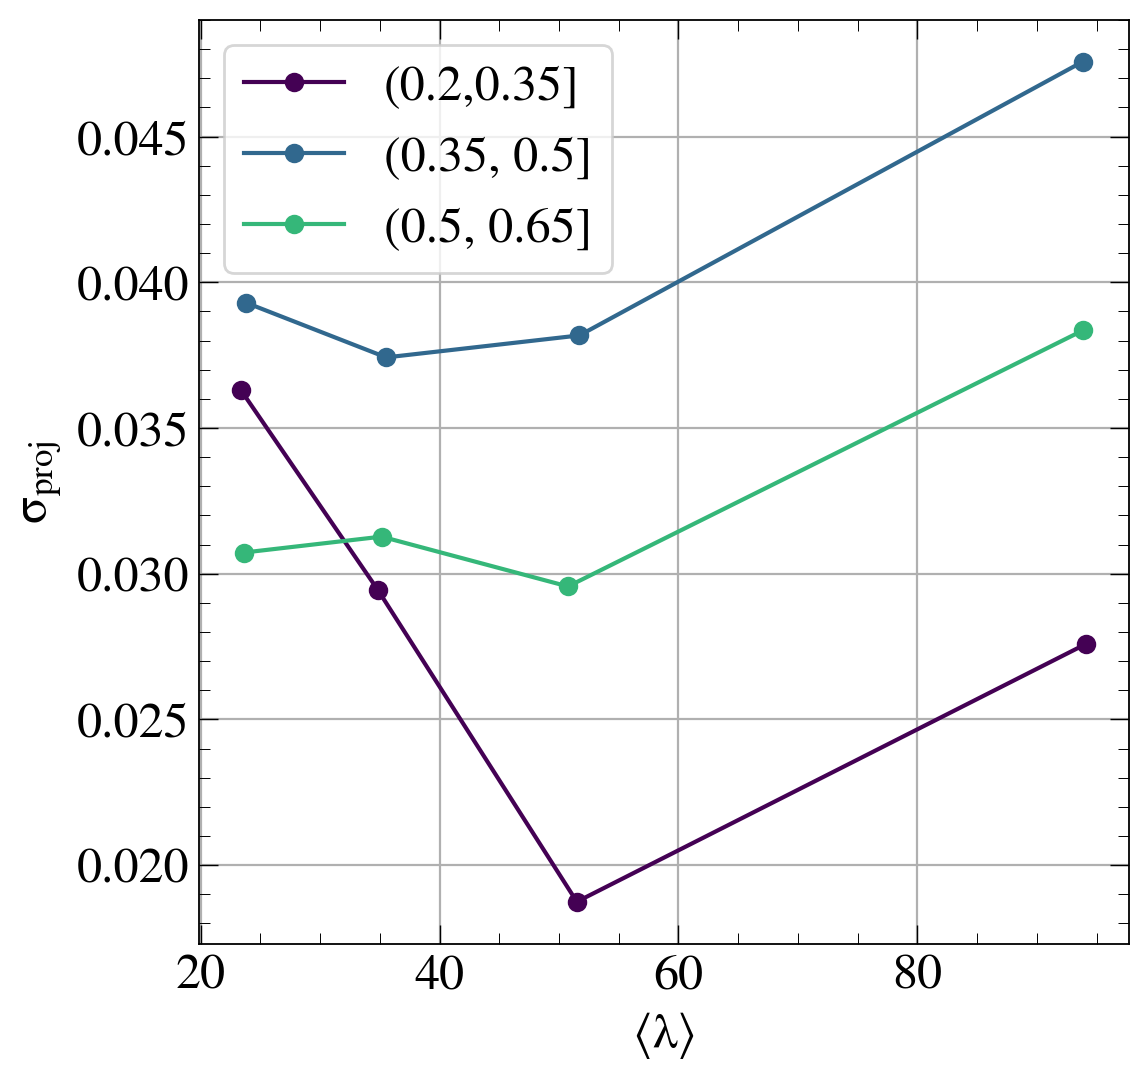

In [21]:
import matplotlib.cm as cm

grouped_cl = redmapper_cl.group_by('redshift_range')
grouped_me = redmapper_me.group_by('redshift_range')

bf_f_proj = np.zeros(len(myles_bin_edges) - 1)
bf_sigma_cl = np.zeros(np.shape(bf_f_proj))
bf_mu_proj = np.zeros(np.shape(bf_f_proj))
bf_sigma_proj = np.zeros(np.shape(bf_f_proj))

# colors = ['red','blue','green','violet','cyan']
cmap = cm.get_cmap('viridis')
group_names = grouped_cl.groups.keys

for c, group_name in enumerate(group_names):
    mean_bin_richness = []
    group_indices = np.where(grouped_cl.groups.keys == group_name)[0]
    start_index = grouped_cl.groups.indices[group_indices[0]]
    end_index = grouped_cl.groups.indices[group_indices[0] + 1] - 1
    
    clusters = grouped_cl[start_index:end_index+1]
    z_BCG = clusters['cg_spec_z'] 
    z_lambda = clusters['z_lambda']
    Lambda = clusters['lambda'] 
    sel = (z_BCG != -1) #& (0.2 <= z_lambda) & (z_lambda <= 0.35)
    ID_cl = clusters['mem_match_id'][sel] 
    z_BCG = z_BCG[sel]
    z_lambda = z_lambda[sel]
    Lambda = Lambda[sel]
    
    
    group_indices = np.where(grouped_me.groups.keys == group_name)[0]
    start_index = grouped_me.groups.indices[group_indices[0]]
    end_index = grouped_me.groups.indices[group_indices[0] + 1] - 1
    
    members = grouped_me[start_index:end_index+1]
    z_mem = members['zspec']
    sel = (z_mem != -1)
    z_mem = z_mem[sel]
    ID_mem = members['mem_match_id'][sel]

    mag_i = np.array([item[2] for item in np.array(members['mag'])])[sel]


    #applying the Lstar filter
    exp = (mag_i - 22.44-3.36*np.log10(z_mem)-0.273*np.log10(z_mem)**2+0.0618*np.log10(z_mem)**3+0.0227*np.log10(z_mem)**4) / -2.5
    lstar_frac = 10**exp
    sel = (lstar_frac >= 0.55)
    z_mem = z_mem[sel]
    ID_mem = ID_mem[sel]

    #filtering out galaxies that don't belong to clusters with z_BCG
    sel = np.isin(ID_mem, ID_cl)
    ID_mem = ID_mem[sel]
    z_mem = z_mem[sel]


    delz = np.array([])
    delzov1pz = np.array([])

    #calculating delta z for each member
    for i in range(len(ID_cl)):
        sel = (ID_mem == ID_cl[i])
        delz = np.concatenate((delz, z_mem[sel] - z_BCG[i]))
        delzov1pz = np.concatenate((delzov1pz, (z_mem[sel] - z_BCG[i]) / (1 + z_BCG[i])))  
        
    for i in range(len(myles_bin_edges) - 1):
        # Selecting halos in current richness bin
        if i != 0:
            sel = (myles_bin_edges[i] < Lambda) & (Lambda <= myles_bin_edges[i+1])
            legend = f'{myles_bin_edges[i]} < λ ≤ {myles_bin_edges[i+1]}'
        else:
            sel = (myles_bin_edges[i] <= Lambda) & (Lambda <= myles_bin_edges[i+1])
            legend = f'{myles_bin_edges[i]} ≤ λ ≤ {myles_bin_edges[i+1]}'

        mean_z = np.mean(z_BCG[sel])  # Needed for converting from redshift to km/s
        sel_ID_cl = ID_cl[sel]  # Getting ID's to select corresponding members

        mean_bin_richness.append(np.mean(Lambda[sel]))  # Getting mean richness for x-axis on plots

         # Selecting members that correspond to halos
        sel = np.isin(ID_mem, sel_ID_cl)
        delzov1pz_sel = delzov1pz[sel]

        # Sorting delta z to make CDF
        sel = np.argsort(delzov1pz_sel)
        delzov1pz_sel = delzov1pz_sel[sel]

        cdf = (np.arange(len(delzov1pz_sel)) + 1.0) / len(delzov1pz_sel)

        bf_params = curve_fit(dbl_gauss_cdf, delzov1pz_sel, cdf, p0=[myles_f_proj[i],velocity_to_dzov1pz(mean_z, myles_sigma_cl[i]),
                                                                     velocity_to_dzov1pz(mean_z, mu_proj), velocity_to_dzov1pz(mean_z, sigma_proj),],)[0]

        if (bf_params[1] < bf_params[3]):

            bf_f_proj[i] = bf_params[0]
            bf_sigma_cl[i] = bf_params[1]
            bf_sigma_proj[i] = bf_params[3]
        else:
            bf_f_proj[i] = 1 - bf_params[0]
            bf_sigma_cl[i] = bf_params[3]
            bf_sigma_proj[i] = bf_params[1]  
    plt.plot(mean_bin_richness, bf_sigma_proj, label=group_name[0], marker='o', color=cmap(c / len(group_names)))
plt.xlabel(r'$\rm \langle \lambda \rangle$')
plt.ylabel(r'$\rm \sigma_{proj}$')
plt.legend()
plt.savefig('Images/skysim_projection_sigma.png', facecolor='white')
plt.show()